## Final Project

Group Members:  <br>

#### ``Objectives``
 - 

---
#### ``Data:``
Data is sourced from an active (June 2023) Kaggle competition: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview

**Data dictionary**:

Files and Field Descriptions
* train.csv - The training set.
  * Id Unique identifier for each observation.
  * AB-GL Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
  * Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
* test.csv - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
* greeks.csv - Supplemental metadata, only available for the training set.
  * Alpha Identifies the type of age-related condition, if present.
    * A No age-related condition. Corresponds to class 0.
    * B, D, G The three age-related conditions. Correspond to class 1.
  * Beta, Gamma, Delta Three experimental characteristics.
  * Epsilon The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

#### ``Decision tree learning``
 - used for classifying non-linearly separable data (can build complex decission bounderies by dividing the feature space into rectangles).
 - based on the features of the training set, the decission tree classifier learns a series of questions to infer the class labels.
 - can be used for both categorical and real numbered variables (if a real number, just define a cut-off value to ask a binary question).
 - we start at the tree root (contains all data) and split the data on the feature that results in the largest **Information Gain (IG)**.
 - using an iterative process, repeat the splitting procedure at each child node until you reach the leaf node (i.e., when the training examples at each node all belong to the same class).
 - be aware of overfitting issues! this can happen if the tree becomes too long! Make sure to **prune** the tree by setting a maximal depth of the tree.

### Step 1: Import Packages

In [1]:
# !pip install mlxtend
# standard 
import numpy as np
import pandas as pd

# data preprocessing
from sklearn import preprocessing

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns #sb
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# prediction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
# from mlxtend.plotting import heatmap

# This tells matplolib not to try opening a new window for each plot
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# For producing decision tree diagrams.
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from sklearn.datasets import load_iris



2023-07-25 22:58:17.152139: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 22:58:17.660007: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 22:58:17.662873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 22:58:20.076357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Step 2: Defining working directories

### Step 3: Define classes

### Step 4: Define Functions

In [2]:
def lin_regplot(X, y, y_pred):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, y_pred, color='black', lw=2)    
    return 

In [3]:
def pct_error_plot(df_b, df_m, plot_type, solution):
    """ Plot relationship between (forecast length, training length) and pct_error
    
    params:
    -------
    df_b: df, predictions using test data for baseline model
    df_m: df, predictions using test data for mobility model
    plot_type: str, you can choose between 'violin', 'box'
    solution: str, 'closed_form' or 'tf'
    
    return:
    -------
    plot
    """

    if solution=='closed_form':
        # add test predictions from both models, baseline and mobility
        df_b['model'] = 'baseline'
        df_m['model'] = "mobility"

        df = pd.concat(
            [df_b, df_m],
            axis=0
        )
    
    if solution=='tf':
        # keep only test test predictions for baseline model
        df = df_b
    
    # add length of forecast (in days) variable
    df['pred_day'] = df.groupby(
        ['adm0_name', 'model'],
        as_index = False)['date'].cumcount() #we have 10 days in forecast (test), this will start count at 0
    
    df['pred_day'] = df['pred_day'] + 1 #starts count at one now
    
    # initialize new figure
    sns.set(rc={'figure.figsize':(5,5)})
    
    
    # plot axes
    ax = sns.catplot(
        x='pred_day',
        y='pct_error',
        hue='model',
        data=df,
        kind=plot_type,
        palette='muted',
        legend=False
    )
    
    # set figure size
    ax.fig.set_figwidth(10)
    ax.fig.set_figheight(6)

    # set title, axes
    plt.title(
        'Percentage error in predicted number of cases at the country level \n train_length = 20 days',
        fontsize = 16
    )
    
    plt.ylabel('pct_error')
    plt.xlabel('length of forecast (days)')
    
    if solution=='baseline':
        ax.set(ylim=(-75, 75))
    
    # add vertical line at y=0
    plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
    
    # set legend
    legend = plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=10,
        prop={'size': 10}
    )
    
    return df

In [4]:
def entropy(distribution):
    ''' Computes the entropy index
    # param distribution: list containing distributions
    # return entropy index
    '''
    entropy_index = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: 
            logprob = np.log2(probability)
        entropy_index -= probability * logprob
        
    return entropy_index

In [5]:
def get_parent_distribution(labels):
    ''' Computes parent distirbution
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    # Initialize counters for all labels to zero.
    label_probs = np.array([0.0 for i in range(len(np.unique(labels)))])

    # Iterate over labels in the training data and update counts.
    for label in labels:
        label_probs[label] += 1.0
    
    # Normalize to get a distribution.
    label_probs /= label_probs.sum()
    
    return label_probs

In [6]:
def information_gain(data, labels, feature, threshold=0):
    ''' Computes information gain
    # param data: an array of featurized examples
    # param labels: an array of labels corresponding to the the data
    # param feature: the feature to use to split the data
    # param threshold: the feature value to use to split the data (the default threshold is good for binary features)
    '''
    # Get the initial entropy of the label distribution.
    initial_entropy = entropy(get_parent_distribution(labels))
    
    # subset0 will contain the labels for which the feature is 0 and
    # subset1 will contain the labels for which the feature is 1.
    subset0, subset1 = [], []
    for datum, label in zip(data, labels):
        if datum[feature] > threshold:
            subset1.append(label)
        else: 
            subset0.append(label)
    
    # Compute the entropy of each subset.
    subset0_entropy = entropy(get_parent_distribution(subset0))
    subset1_entropy = entropy(get_parent_distribution(subset1))
    
    # Compute the final entropy by weighting each subset's entropy according to its size.
    subset0_weight = 1.0 * len(subset0) / len(labels)
    subset1_weight = 1.0 * len(subset1) / len(labels)
    final_entropy = subset0_weight * subset0_entropy + subset1_weight * subset1_entropy
    
    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy

In [7]:
def try_features_and_thresholds(data, labels):
    ''' Computes thresholds for each features and returns the threshold that optimized information gain
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    print('feature', 'best_threshold', 'best_IG', 'feature name')
    for feature in range(data.shape[1]):
        # Choose a set of thresholds between the min- and max-valued feature, ignoring the min and max themselves.
        thresholds = np.linspace(data[:,feature].min(), data[:,feature].max(), 20)[1:-1]

        # Try each threshold and keep track of the best one for this feature.
        best_threshold = 0
        best_IG = 0
        for threshold in thresholds:
            IG = information_gain(data, labels, feature, threshold)
            if IG > best_IG:
                best_IG = IG
                best_threshold = threshold

        # Show the best threshold and information gain for this feature.
        
        print ('%d %.3f %.3f %s' %(feature, best_threshold, best_IG, features[feature]))

### Step 5: Read Data

In [8]:
df_train = pd.read_csv(
    '../data/train.csv',
    delimiter='\,'
)

df_test= pd.read_csv(
    '../data/test.csv',
    delimiter='\,'
)

df_train.head(10)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
5,04517a3c90bd,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,...,0.173229,0.49706,1.164956,21.915512,72.611063,24177.595550,28.525186,82.527764,21.978000,0
6,049232ca8356,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,...,4.408484,0.86130,0.467337,17.878444,192.453107,3332.467494,34.166222,100.086808,0.065096,0
7,057287f2da6d,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,...,6.591896,0.49706,0.277693,18.445866,109.693986,21371.759850,35.208102,31.424696,0.092873,0
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,4.762291,1.18262,0.067730,17.245908,147.218610,4589.611956,29.771721,54.675576,0.073416,0
9,05f2bc0155cd,0.324748,5188.68207,85.200147,12.968687,8.138688,4.593392,0.025578,10.685041,1.229900,...,0.173229,1.57151,0.318331,24.515421,98.929757,5563.130949,21.994831,33.300970,21.978000,0


In [9]:
df_train.shape

(617, 58)

In [10]:
df_greeks = pd.read_csv('../data/greeks.csv')
df_greeks.shape

(617, 6)

In [11]:
df_greeks.head(5)

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [12]:
df = pd.merge(df_train, df_greeks, on='Id')
df.shape

(617, 63)

In [13]:
df.head(10)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020
5,04517a3c90bd,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,...,24177.595550,28.525186,82.527764,21.978000,0,A,C,M,B,10/1/2019
6,049232ca8356,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,...,3332.467494,34.166222,100.086808,0.065096,0,A,C,M,B,5/29/2019
7,057287f2da6d,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,...,21371.759850,35.208102,31.424696,0.092873,0,A,C,M,B,4/24/2019
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,4589.611956,29.771721,54.675576,0.073416,0,A,C,M,B,2/18/2019
9,05f2bc0155cd,0.324748,5188.68207,85.200147,12.968687,8.138688,4.593392,0.025578,10.685041,1.229900,...,5563.130949,21.994831,33.300970,21.978000,0,A,B,M,B,6/19/2020


In [14]:
df_test #1% is test split 617 rows for training - can do a new test split from training

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 6: Data preprocessing

#### Step 6.1 Data subseting

In [15]:
df.rename(columns = {'Class':'class_label'}, inplace = True)
# shift column 'class_label' to first position
first_column = df.pop('class_label')
df.insert(0, 'class_label', first_column)
df

,class_label,Id,AB,AF,AH,AM,AR,AX,AY,AZ,...,GE,GF,GH,GI,GL,Alpha,Beta,Gamma,Delta,Epsilon
0,1,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,...,72.611063,2003.810319,22.136229,69.834944,0.120343,B,C,G,D,3/19/2019
1,0,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,...,72.611063,27981.562750,29.135430,32.131996,21.978000,A,C,M,B,Unknown
2,0,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,...,88.609437,13676.957810,28.022851,35.192676,0.196941,A,C,M,B,Unknown
3,0,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,...,82.416803,2094.262452,39.948656,90.493248,0.155829,A,C,M,B,Unknown
4,1,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,...,146.109943,8524.370502,45.381316,36.262628,0.096614,D,B,F,B,3/25/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,...,217.148554,8095.932828,24.640462,69.191944,21.978000,A,B,M,B,9/13/2020
613,0,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,...,496.994214,3085.308063,29.648928,124.808872,0.145340,A,B,M,B,9/8/2020
614,0,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,...,128.896894,6474.652866,26.166072,119.559420,21.978000,A,C,M,B,7/24/2019
615,0,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,...,72.611063,1965.343176,25.116750,37.155112,0.184622,A,C,M,B,1/31/2019


``split data into training and test``

In [16]:
# define outcome #
##################
y = df['class_label'].values

# define features #
###################
X = df.drop(labels=['Id', 'Alpha','Beta', 'Gamma','Delta','Epsilon'], axis=1).values

# split #
#########
split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns= ['class_label'] + list(df.drop(labels=['Id', 'Alpha','Beta', 'Gamma','Delta','Epsilon'], axis=1).columns)
df_train = df_train.iloc[: , 1:]
df_train

,class_label,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,1,0.457211,3347.39966,355.100766,6.47273,8.138688,5.408419,0.025578,10.978084,1.2299,...,10.105329,2.336948,1.50626,0.06773,8.250874,72.611063,5080.256658,46.720876,21.53407,1.527429
1,0,0.217923,5735.54762,85.200147,24.004847,8.138688,6.422775,0.025578,5.879766,4.561172,...,11.599352,0.173229,1.92038,0.06773,11.181004,251.715996,17084.31037,17.801264,18.384656,21.978
2,0,0.307656,4043.89986,85.200147,15.20627,8.138688,6.307608,0.025578,13.479978,1.2299,...,11.527683,4.132436,0.49706,0.257374,17.850538,72.611063,3301.827624,39.457484,40.14892,0.161085
3,0,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.2299,...,8.026928,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.11675,37.155112,0.184622
4,0,0.337567,1730.8082,85.200147,19.91371,8.138688,3.392997,0.025578,9.289148,1.2299,...,10.52983,18.988923,1.09678,1.530698,13.450692,72.611063,6511.022676,42.646381,11.898072,0.0495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,0,0.273472,2310.59664,85.200147,13.217996,8.138688,5.377413,0.071862,13.599716,1.2299,...,11.610378,0.173229,1.60254,0.06773,28.212966,72.611063,30045.93329,32.294559,28.675228,21.978
427,1,0.636677,2996.11246,85.200147,157.135586,25.533036,4.934463,0.025578,12.660718,1.2299,...,10.19905,36.144542,0.49706,0.13546,11.562386,145.420891,7134.676344,16.833804,48.536212,0.027231
428,0,0.188012,2663.06601,85.200147,11.957517,8.138688,5.023053,0.030755,3.724482,2.164624,...,9.879296,0.173229,1.45493,0.06773,15.552944,1080.230354,12484.41296,30.608946,66.635376,21.978
429,0,0.155965,2554.69236,85.200147,10.08538,8.138688,3.410715,0.025578,10.68189,1.2299,...,10.976383,0.173229,0.49706,0.189644,13.125122,72.611063,25422.74651,41.020304,33.35884,21.978


In [17]:
features =[]
for col in df_train.columns:
    features.append(col)
    

labels = ['class_label']
features

['class_label',
 'AB',
 'AF',
 'AH',
 'AM',
 'AR',
 'AX',
 'AY',
 'AZ',
 'BC',
 'BD ',
 'BN',
 'BP',
 'BQ',
 'BR',
 'BZ',
 'CB',
 'CC',
 'CD ',
 'CF',
 'CH',
 'CL',
 'CR',
 'CS',
 'CU',
 'CW ',
 'DA',
 'DE',
 'DF',
 'DH',
 'DI',
 'DL',
 'DN',
 'DU',
 'DV',
 'DY',
 'EB',
 'EE',
 'EG',
 'EH',
 'EJ',
 'EL',
 'EP',
 'EU',
 'FC',
 'FD ',
 'FE',
 'FI',
 'FL',
 'FR',
 'FS',
 'GB',
 'GE',
 'GF',
 'GH',
 'GI',
 'GL']

#### EDA

Prior to training a model it is important to perform exploratory data analysis. The idea is to detect any missing data, the presence of outliers, the feature distribution, and the relationship between features and outcome. Note that typically there is a back and forth between Step 4 and 5, depending on how satisfied you are with the results of the EDA.

Note: I am going to perform EDA with the non-standardized feature values but when we fit the model.


`` check if any missing values``

In [18]:
df_train.isna().sum()


class_label     0
AB              0
AF              0
AH              0
AM              0
AR              0
AX              0
AY              0
AZ              0
BC              0
BD              0
BN              0
BP              0
BQ             44
BR              0
BZ              0
CB              2
CC              3
CD              0
CF              0
CH              0
CL              0
CR              0
CS              0
CU              0
CW              0
DA              0
DE              0
DF              0
DH              0
DI              0
DL              0
DN              0
DU              1
DV              0
DY              0
EB              0
EE              0
EG              0
EH              0
EJ              0
EL             43
EP              0
EU              0
FC              1
FD              0
FE              0
FI              0
FL              1
FR              0
FS              2
GB              0
GE              0
GF              0
GH              0
GI        

``check distributions``

using describe()

In [19]:
df_train.describe()

,class_label,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
count,431,431.000000,431.00000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.0000,...,431.00000,430.000000,431.00000,429.00000,431.000000,431.000000,431.000000,431.000000,431.000000,430.000
unique,2,185.000000,423.00000,165.000000,425.000000,88.000000,329.000000,108.000000,353.000000,177.0000,...,367.00000,271.000000,300.00000,141.00000,408.000000,191.000000,427.000000,419.000000,429.000000,254.000
top,0,0.260653,192.59328,85.200147,14.221424,8.138688,0.699861,0.025578,3.396778,1.2299,...,3.58345,0.173229,0.49706,0.06773,19.227234,72.611063,13.038894,28.454487,15.447432,21.978
freq,359,10.000000,9.00000,267.000000,2.000000,342.000000,5.000000,296.000000,51.000000,253.0000,...,14.00000,159.000000,121.00000,126.00000,2.000000,241.000000,5.000000,2.000000,2.000000,160.000


using hist()

In [20]:
len(df_train.columns)

57

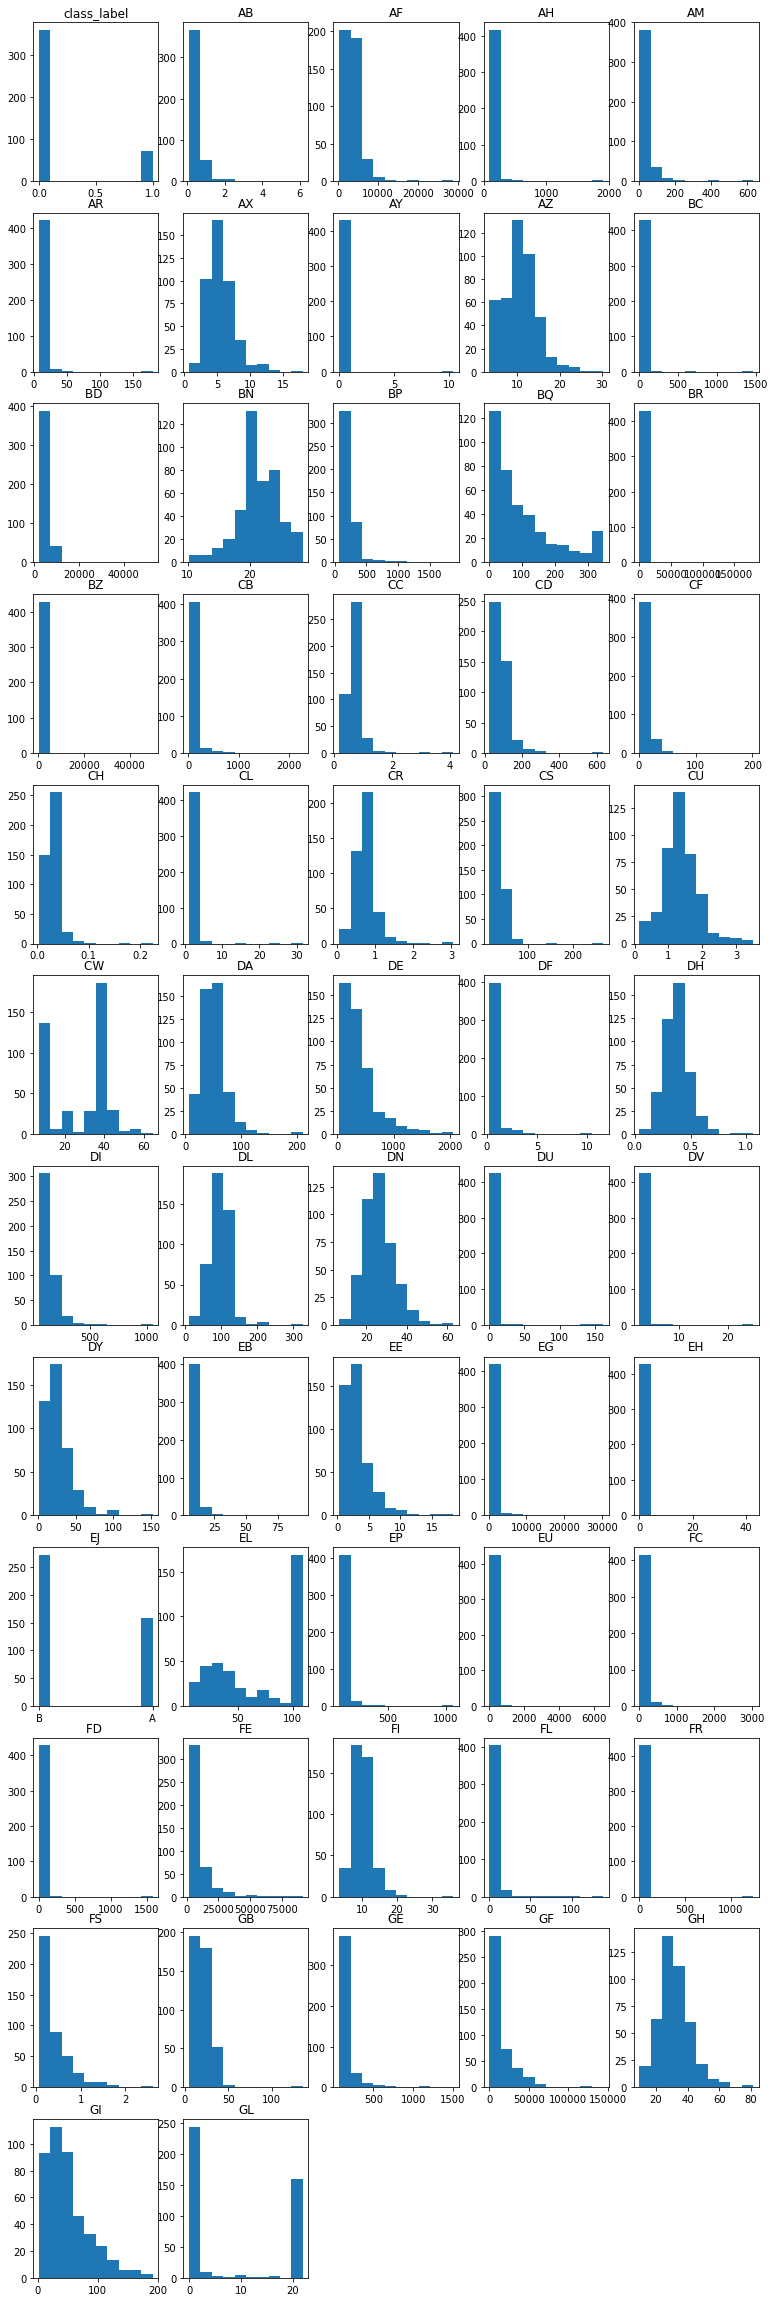

In [21]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 57 features
    
plt.figure(figsize=(13, 45))

# Iterate over the features, creating a subplot with a histogram for each one.
for idx, feature in enumerate(features):
    plt.subplot(13, 5, idx+1)
    df_train[feature].hist(bins=10, grid=False)
    plt.title(feature)

``correlation matrix of outcome and feature variables``

In [ ]:
df_train = pd.get_dummies(df_train, drop_first=True)
cm = df_train.corr().values
hm = heatmap(
    cm,
    row_names=df_train.columns,
    column_names=df_train.columns
)

#### Step 6.2 Binarize feature values
To make things simple, let's binarize these feature values. That is, we'll treat each measurement as either "low"=0 or "high"=1. I'm just going to choose a threshold for each feature. Threshold = mean value of the feature.

In [ ]:
binarize_threshold = []
df_b = df_train

for feature in features:
    df_b[feature] = np.where(df_b[feature] >= df_b[feature].mean(), 1, 0)
    binarize_threshold.append(df_b[feature].mean())
print('Binarize thresholds:\n', binarize_threshold)
df_b.head()

In [ ]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(15, 3))

# Iterate over the features, creating a subplot with a histogram for each one.
for idx, feature in enumerate(features):
    plt.subplot(1, 4, idx+1)
    df_b[feature].hist(bins=10, grid=False)
    plt.title(feature)

In [ ]:
summary_table = pd.DataFrame(df_b.groupby(['class_label', 'alcohol']).agg({'alcohol':['count']}).reset_index())
summary_table.columns=['class_label', 'alcohol', 'count']
summary_table = pd.pivot(summary_table, index = "alcohol", columns = "class_label", values= 'count')
summary_table['total'] = summary_table.loc[:, 0] + summary_table.loc[:, 1] + summary_table.loc[:, 2]
summary_table

### Step 7: Decision Tree Classifier

Based on the features in the disease dataset, the decision tree algo learns a series of questions to make predictions about class labels. 

The decission tree algo starts at the tree root (contains all data) and splits the data on the feature that results in the largest **Information Gain (IG)**.

Using an iterative process, the algo repeats the splitting procedure at each child node until a leaf node is reached (i.e., when the training examples at each node all belong to the same class).

---

#### Question: How do we decide what are the most informative features (a.k.a., child nodes)? 

---
**Objective**: maximize the **Information Gain (IG)** at each node split:

$IG(D_p,f) = I(D_p) - \sum_{j=1}^{m} \frac{N_j}{N_p} I(D_j)$,

where:
- $D_p$ = dataset of the parent node
- $D_j$ = dataset of the j_th child node
- $f$ = f is the feature to perform the split
- $I$ = our Impurity measure (we will use Entropy)
- $N_p$ = total number of training examples at the parent node
- $N_j$ = total number of training examples at the child j_th node

So the IG is the difference between the impurity of the parent node and the sum of the child node impurities (the lower the impurities of the child nodes, the larger the information gain).

For efficiency, most libraries (incl. scikit-learn) implement binary decission trees, meaning that each parent node is split into two child nodes: <br>
$IG(D_p,f) = I(D_p) - [\frac{N_j}{N_p} I(D_{left}) + \frac{N_j}{N_p} I(D_{right})]$,
We are missing only one thing, the definition of our impurity measure (**entropy**):

$I(t) = -\sum_{i=1}^{c} p(i|t) \times log_2 p(i|t)$

where:
- $p(i|t)$ is the proportion of examples that belong to class $i$ for a particular node, $t$

So the entropy is zero if all example at a node belong to the same class, and it's maximal if we have a uniform distribution (even split between class labels). In other words, entropy is a measure of uncertainty, and it is maximized when the distribution is uniform.

In [ ]:
# Show a plot of the entropy, I(X), of a Bernoulli random variable X.
p_values = np.linspace(0, 1, 50)
entropies = [entropy([p, 1-p]) for p in p_values]  #Note: the entropy function is defined at the top
plt.figure(figsize=(4,4))
plt.plot(p_values, entropies, 'o')
plt.xlabel('P(X=1)');
plt.ylabel('I(X)');

#### Step 7.1 Compute the impurity (entropy) of the parent dataset

In other words, we are interested in the entropy of our distribution over labels. You may recall that the distribution in the training data is nearly uniform.

In [ ]:
label_probs = get_parent_distribution(y_b_train)
print ('Parent distribution', label_probs)
# Compare the label entropy to a uniform distribution.
print ('Parent entropy:', entropy(label_probs))
print ('Uniform entropy:', entropy([1./3, 1./3, 1./3]))

#### Step 7.1 Compute the impurity of the child nodes
In other words, we want to look at the entropy of each subset of the labels after splitting on each feature. 

Note: no code here because this step is included in the information_gain() function. I will leave it to you to split it in a separate function.

In [ ]:
features

#### Step 7.2 Compute the information gain (IG) for each feature

In [ ]:
for feature in range(len(features)):
    IG = information_gain(X_b_train, y_b_train, feature)
    print ('%d %.3f %s' %(feature, IG, features[feature]))

According to the information gain metric, -- is the most useful feature, followed by --. Let's confirm that this agrees with the sklearn decision tree implementation. Actually, sklearn doesn't expose the information gain values. Instead, it stores the distribution of "feature importances", which reflects the value of each feature in the full decision tree. Let's train a decision tree with max_depth=1 so it will only choose a single feature. Let's also get the test accuracy with this "decision stump".

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(X_b_train, y_b_train)
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(X_b_test, y_b_test))

---
We've been using the binarized version of the wine features. Recall that we simply chose thresholds for each feature by taking the mean of each feature. Let's use **information gain (IG)** as a metric to choose a best feature and a best threshold.

In [ ]:
try_features_and_thresholds(X_train, y_train)

Let's try training actual decision trees (as opposed to stumps) with the original (non-binarized) data. You may need to install GraphViz before exporting the tree.

In [ ]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='gini', max_depth=3)
clf = dt.fit(X_train, y_train)
print ('Accuracy:', dt.score(X_test, y_test))
tree.plot_tree(clf);

print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
#tree.export_graphviz(clf)

If you successfully output the tree, you should be able to see it here. The first split did not perfectly separate the classes. The next split iwas better at separating classes. At this point, we stop splitting because we don't have enough samples to be convinced that further splitting would generalize well (check what happens if you set the max_depth parameter >2.

Note: a depth 3 tree gets 78% accuracy on the test data. A depth 2 gets 82%! Tree pruning, which is not implemented in sklearn, can be useful for choosing a depth that generalizes well.